In [20]:
import arff
import argparse
import ConfigSpace
import logging
import numpy as np
import openmlcontrib
import openmldefaults
import os
import pandas as pd
import pickle
import sklearn
import typing
import pdb
import sys
import logging
import numba

In [21]:
from pathlib import Path
configs = {
    "sklearn_svc": {
        "path" : Path('/home/flo/Documents/projects/surrogates_data/data'),
        "file" : 'sklearn_svc.arff',
        "target_col": ["predictive_accuracy"],
        "task_col": "task_id",
        "cat_names" : ['svc__kernel', 'svc__shrinking', 'columntransformer__numeric__imputer__strategy'],
        "cont_names" : ['svc__'+s for s in ['C', 'coef0', 'degree', 'gamma', 'tol']]
    },
    "mlr_svm_2": {
        "path" : Path('/home/flo/Documents/projects/surrogates_data/data'),
        "file" : 'rbv2_mlr_classif.svm.arff',
        "target_col": ["perf.mmce", "perf.logloss", "traintime", "predicttime"],
        "task_col": "dataset",
        "cat_names" : ['kernel', 'shrinking', 'num.impute.selected.cpo', 'fitted'],
        "cont_names" : ['cpst', 'gamma', 'tolerance', 'degree']
    }
}

In [22]:
import pandas as pd
import openmlcontrib
def read_data(path, file, task_col):
    fp = path/file
    if (fp).suffix == ".arff": 
        if "mlr" not in file:
            with open(fp) as arff_file:
                df = openmlcontrib.meta.arff_to_dataframe(arff.load(arff_file))
                df.task_id = df[task_col].astype('int').astype('str')
        else:
             df = pd.read_csv(fp,nrows=70)
    else:
        df = pd.read_csv(fp)
        df.task_id = df[task_col].astype('int').astype('str')
    return df

def split_by_task_id(df, task_col, frac=0.2):
    vidx = df.groupby(task_col).apply(pd.DataFrame.sample, frac=frac).index.droplevel(task_col).values
    tidx = [x for x in df.index.values if x not in vidx]
    return (L(tidx), L(vidx.tolist()))

def normalize(x):
    if (max(x) == min(x)):
        return np.ones_like(x)*0.5
    else:
        return (x - min(x)) / (max(x) - min(x))

def normalize_target(df, task_col, target_col):
    df[target_col] = df.groupby(task_col)[target_col].apply(normalize)
    return df

def identity_y(): return TransformBlock()

def sprho(inp, targ):
    return scipy.stats.spearmanr(inp, targ)[0]

In [23]:
from fastai2.tabular.all import *
path, file, target_col, task_col, cat_names, cont_names =  configs["sklearn_svc"].values()
target_col = target_col[0]
df = read_data(path, file, task_col)
df = normalize_target(df, task_col, target_col)

# Fit the NN

In [15]:
procs = [Categorify, FillMissing, Normalize]
splits = split_by_task_id(df, task_col)
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=target_col, splits=splits, block_y=identity_y)
dls = to.dataloaders(bs=512)

In [16]:
learn = tabular_learner(dls, [1000,500,300], metrics=[mae,sprho], n_out=1,loss_func=MSELossFlat(), opt_func=ranger)

(0.0019054606556892395, 0.0003311311302240938)

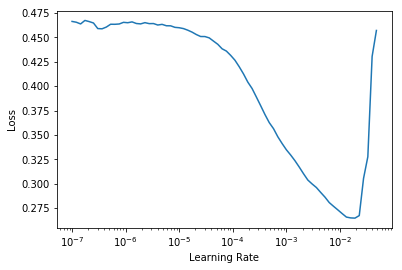

In [17]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,mae,sprho,time
0,0.094552,0.095026,0.247550,0.388537,00:06
1,0.089140,0.084124,0.236778,0.437576,00:06
2,0.081746,0.082926,0.232182,0.448092,00:06


In [ ]:
row = df.iloc[[0],:].drop(["predictive_accuracy"],axis=1)
hout_tid = 33
tids = [x for x in df.task_id.unique() if x != hout_tid]

def predict_mean(learn, row, tids):
    pdf = row.loc[np.repeat(row.index.values, len(tids))]
    pdf.task_id = tids
    return pdf.reset_index().drop(["index"],axis=1)

In [ ]:
rows.head()

# Optimizing the Architecture

In [ ]:
import torch
import numpy as np

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

init_notebook_plotting()

def train_evaluate(p):
    net = learn = tabular_learner(dls, [p['l1'], p['l3'], p['l3']], metrics=mae, wd = p['wd'], config = tabular_config(y_range=[0,1.1]), n_out=1)
    learn.fit(10, lr=p['lr'])
    tt = learn.get_preds()
    return scipy.stats.spearmanr(tt[1].numpy(), tt[0].numpy()).correlation

In [ ]:
# Ooṕtimize using Ax
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "wd", "type": "range", "bounds": [0.0, 0.1]},
        {"name": "l1", "type": "range", "bounds": [1, 512]},
        {"name": "l2", "type": "range", "bounds": [1, 512]},
        {"name": "l3", "type": "range", "bounds": [1, 512]},
    ],
    evaluation_function=train_evaluate,
    objective_name='rho',
    total_trials=100
)

In [ ]:
best_parameters